In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
import torch
import pyvene as pv
import pprint
from task import MetaLearningTask, FineTuningTask
from transformers import BatchEncoding, PretrainedConfig
import jax.random as jr
from torch2jax import j2t, t2j
import dataclasses
import pyreft
import nvidia_smi
from models.mamba import MambaLMHeadModel
from dataclasses import dataclass
from mamba_ssm.utils.generation import InferenceParams
from task import DynamicIntervenableModel, TuneConfig, LoraConfig, ReftConfig
import gc
from models.gpt import GPT, GPTConfig
from models.mamba import MambaLMHeadModel, MambaConfig
from pympler import asizeof
from data.hmm import CompositionalHMMDataset, CompositionalHMMDatasetConfig
import lightning as L
from torch.nn import init
from peft import PeftModel, LoraModel
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import jax
from dynamax.hidden_markov_model.parallel_inference import (
    HMMPosteriorFiltered,
    _condition_on,
    FilterMessage,
    lax,
)

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

In [2]:
IDS = {'mamba': 'ale6kz0k', 'gpt': 'duy6u49u'}

In [3]:
task = MetaLearningTask(IDS['mamba'])

number of parameters: 10.44M
Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt


In [5]:
data = task.full_data

In [6]:
X,Z = data.sample(6144, 100, jr.PRNGKey(0))

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [22]:
oracle = data.bayesian_oracle(jnp.arange(len(data)), X)

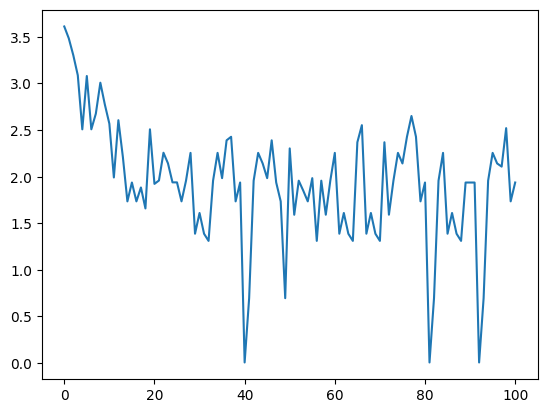

In [19]:
plt.plot(-(jnp.log(oracle['post_pred'])*oracle['post_pred']).sum(-1))

In [20]:
t = jnp.linspace(0,100,1000)

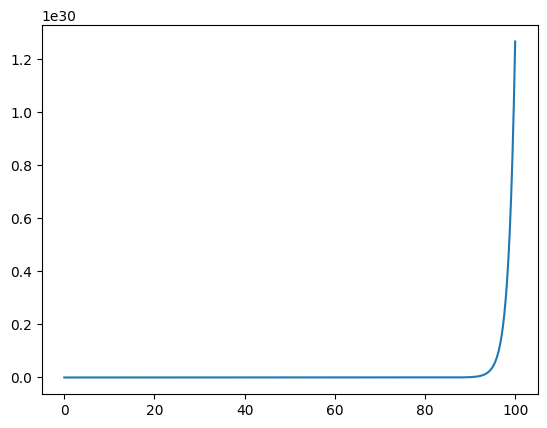

In [21]:
plt.plot(t, 2**t)

In [25]:
task = FineTuningTask(
    TuneConfig(
        IDS["gpt"],
        method_config=LoraConfig(r=4, target_modules="all-linear"),
        context_length=[100,100],
        constraints=[[1, 0]],
        precompute_pp=True,
        prefix_size=[30,60]
    )
).cuda()

number of parameters: 10.67M
Loaded dataset : (11288/1000)


Seed set to 42


Loaded checkpoing : last.ckpt


In [38]:
task.model.disable_adapter()

In [43]:
task.model.__class__.__name__

'PeftModel'

In [31]:
a=a

In [29]:
next(iter(task.val_dataloader()[0]))

{'input_ids': tensor([[12,  1,  1,  ..., 47,  2, 28],
         [ 5, 29,  2,  ..., 16,  0, 42],
         [43, 42, 11,  ...,  2, 15, 12],
         ...,
         [40, 43, 31,  ..., 49,  8, 47],
         [21, 41, 27,  ..., 40, 40, 39],
         [35, 21, 47,  ..., 27, 42,  2]], device='cuda:0', dtype=torch.int32),
 'states': tensor([[ 0,  1, 19,  ..., 14, 10,  3],
         [14,  9, 11,  ...,  2,  1,  5],
         [ 7, 12, 19,  ...,  9,  3,  1],
         ...,
         [ 0,  8, 12,  ...,  7,  6, 15],
         [ 6, 18,  0,  ...,  5, 17, 10],
         [ 7,  6, 18,  ...,  0,  8, 12]], device='cuda:0', dtype=torch.int32),
 'raw_seqs': tensor([[12,  1,  1,  ..., 36,  2, 35],
         [ 5, 29,  2,  ..., 39, 41, 40],
         [43, 42, 11,  ..., 25, 17, 36],
         ...,
         [40, 43, 31,  ..., 43, 47, 21],
         [21, 41, 27,  ..., 29, 36, 10],
         [35, 21, 47,  ..., 33,  2, 15]], device='cuda:0', dtype=torch.int32),
 'raw_states': tensor([[ 0,  1, 19,  ...,  9,  3, 12],
         [14,  9

In [13]:
from torch.utils.data import DataLoader

In [18]:
asdf = DataLoader(
    task.val_data['active'],
    batch_size=32,
    collate_fn=lambda x: x
)

In [16]:
ll, post = jax.vmap(task.full_data.filter, (0,None))(jnp.arange(len(task.full_data)), X)

In [36]:
task_ = FineTuningTask(
    TuneConfig(
        IDS["gpt"],
        method_config=ReftConfig(
            reft_cls="loreft",
            low_rank_dimension=38,
            layers=[1,2,3,4,5],
            t_slice=(-1, None, -1),
            component="output",
        ),
        context_length=[50, 50],
        constraints=[[1, 0], [2, 0], [4, 1], [6, 0], [7, 0]],
        precompute_pp=False,
        prefix_size=(20, 30),
    )
).cuda()

number of parameters: 10.67M
Loaded dataset : (11288/1000)


Seed set to 42


Loaded checkpoing : last.ckpt


In [1]:
task_.trainable_parameters()

NameError: name 'task_' is not defined

In [12]:
trainer = L.Trainer(
    max_steps=100,
    accelerator="gpu",
    enable_checkpointing=False,
    val_check_interval=50,
    reload_dataloaders_every_n_epochs=1,
    check_val_every_n_epoch=None,
)


/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mila/l/leo.gagnon/latent_control/venv/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
